In [ ]:
!pip install emoji datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import re
import emoji
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import copy
import random
from sklearn.metrics import accuracy_score, f1_score
import os
import requests
from tqdm import tqdm
from datasets import load_dataset
import pickle


In [ ]:
# Text preprocessing class
class TextPreprocessor:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Common internet slang and abbreviations dictionary
        self.slang_dict = {
            "u": "you",
            "r": "are",
            "y": "why",
            "lol": "laughing out loud",
            "idk": "i do not know",
            "tbh": "to be honest",
            "imo": "in my opinion",
            "omg": "oh my god",
            "gonna": "going to",
            "wanna": "want to",
            "gimme": "give me"
        }

    def clean_text(self, text):
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Process emojis (preserve sentiment information)
        text = emoji.demojize(text)
        text = re.sub(r':[a-z_]+:', lambda x: ' ' + x.group(0).replace('_', ' ').replace(':', '') + ' ', text)

        # Convert to lowercase
        text = text.lower()

        # Handle common abbreviations
        words = text.split()
        text = ' '.join(self.slang_dict.get(word, word) for word in words)

        # Handle contractions
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)

        # Remove special characters and extra punctuation
        text = re.sub(r'[^\w\s\']', ' ', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def augment_data(self, texts, labels):
        """Data augmentation method"""
        augmented_texts = []
        augmented_labels = []

        for text, label in zip(texts, labels):
            # Add original data
            augmented_texts.append(text)
            augmented_labels.append(label)

            # Augment minority class (assuming label=1 is minority)
            if label == 1:
                words = text.split()
                if len(words) > 5:  # Only process longer texts
                    # Using reverse as a simple augmentation example
                    augmented_text = ' '.join(words[::-1])
                    augmented_texts.append(augmented_text)
                    augmented_labels.append(label)

        return augmented_texts, augmented_labels

    def prepare_data(self, texts, labels, max_length=128):
        # Encode texts
        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )

        return (
            encodings['input_ids'],
            encodings['attention_mask'],
            torch.tensor(labels)
        )

# Model training class
class SentimentClassifier:
    def __init__(self, num_labels=3):
        # Use GPU (cuda) or CPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=num_labels
        ).to(self.device)

    def train(self, train_dataloader, val_dataloader, epochs=3):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5)
        best_val_loss = float('inf')
        best_model = None

        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}:')
            progress_bar = tqdm(train_dataloader, desc='Training')
            self.model.train()
            train_loss = 0
            for batch in progress_bar:
                optimizer.zero_grad()
                input_ids = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                labels = batch[2].to(self.device)

                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                train_loss += loss.item()
                loss.backward()
                optimizer.step()
                progress_bar.set_postfix({'loss': loss.item()})

            # Validation
            val_loss, val_predictions, val_labels = self.evaluate(val_dataloader)
            val_metrics = self.calculate_metrics(val_labels, val_predictions)

            print(f'Epoch {epoch+1}:')
            print(f'Average training loss: {train_loss/len(train_dataloader)}')
            print(f'Validation metrics: {val_metrics}')

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(self.model.state_dict())

        # Load best model
        if best_model:
            self.model.load_state_dict(best_model)

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        predictions = []
        actual_labels = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                labels = batch[2].to(self.device)

                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()
                predictions.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
                actual_labels.extend(labels.cpu().numpy())

        return total_loss, predictions, actual_labels

    def calculate_metrics(self, true_labels, predictions):
        """Calculate various evaluation metrics"""
        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'macro_f1': f1_score(true_labels, predictions, average='macro'),
            'weighted_f1': f1_score(true_labels, predictions, average='weighted'),
            'per_class_f1': f1_score(true_labels, predictions, average=None)
        }

    def test_robustness(self, text, n_augmentations=5):
        """Test model robustness to text variations"""
        predictions = []
        augmented_texts = self.create_text_variations(text, n_augmentations)

        for aug_text in augmented_texts:
            inputs = self.tokenizer(
                aug_text,
                return_tensors='pt',
                truncation=True,
                padding=True
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model(**inputs)
                pred = outputs.logits.argmax(dim=-1).item()
                predictions.append(pred)

        from statistics import mode
        main_prediction = mode(predictions)
        consistency = predictions.count(main_prediction) / len(predictions)

        return main_prediction, consistency

    def create_text_variations(self, text, n_variations):
        """Create text variations for robustness testing"""
        variations = [text]

        # 1. Add random characters
        text_with_noise = ''.join([c + ' ' if random.random() < 0.1 else c for c in text])
        variations.append(text_with_noise)

        # 2. Random case transformation
        text_case = ''.join([c.upper() if random.random() < 0.3 else c for c in text])
        variations.append(text_case)

        # 3. Add spelling errors
        words = text.split()
        misspelled = []
        for word in words:
            if len(word) > 3 and random.random() < 0.2:
                pos = random.randint(0, len(word)-1)
                word = word[:pos] + word[pos+1:]
            misspelled.append(word)
        variations.append(' '.join(misspelled))

        return variations[:n_variations]

# Visualization class
class VisualizationTools:
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, labels):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    @staticmethod
    def plot_training_history(history):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Training Accuracy')
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.title('Accuracy Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def generate_wordcloud(texts, labels, title="Word Cloud"):
        """Generate word clouds for different sentiments"""
        from wordcloud import WordCloud
        import jieba
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        sentiment_names = ['Negative', 'Neutral', 'Positive']

        for idx, sentiment in enumerate([0, 1, 2]):
            sentiment_texts = ' '.join([text for text, label in zip(texts, labels) if label == sentiment])

            wordcloud = WordCloud(
                width=800, height=400,
                background_color='white',
                max_words=100
            )

            wordcloud.generate(sentiment_texts)
            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].axis('off')
            axes[idx].set_title(f'{sentiment_names[idx]} sentiment word cloud')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_sentiment_distribution(labels):
        """Plot sentiment distribution pie chart"""
        plt.figure(figsize=(10, 8))
        sentiment_counts = pd.Series(labels).value_counts()
        plt.pie(
            sentiment_counts.values,
            labels=['Negative', 'Neutral', 'Positive'],
            autopct='%1.1f%%',
            colors=['#FF9999', '#66B2FF', '#99FF99']
        )
        plt.title('Sentiment Distribution')
        plt.show()

    @staticmethod
    def plot_text_length_distribution(texts, labels):
        """Plot text length distribution for each sentiment"""
        lengths = [len(text.split()) for text in texts]
        sentiment_df = pd.DataFrame({
            'Text Length': lengths,
            'Sentiment': ['Negative' if l == 0 else 'Neutral' if l == 1 else 'Positive' for l in labels]
        })

        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Sentiment', y='Text Length', data=sentiment_df)
        plt.title('Text Length Distribution by Sentiment')
        plt.show()

    @staticmethod
    def plot_top_words(texts, labels, top_n=20):
        """Plot the most common words for each sentiment"""
        from collections import Counter
        import jieba

        plt.figure(figsize=(15, 12))
        sentiment_names = ['Negative', 'Neutral', 'Positive']

        for idx, sentiment in enumerate([0, 1, 2]):
            sentiment_texts = ' '.join([text for text, label in zip(texts, labels) if label == sentiment])

            words = jieba.cut(sentiment_texts)
            word_counts = Counter(words)

            top_words = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n])

            plt.subplot(3, 1, idx+1)
            plt.barh(list(top_words.keys()), list(top_words.values()))
            plt.title(f'{sentiment_names[idx]} sentiment most common words')

        plt.tight_layout()
        plt.show()

def download_datasets():
    """Download and prepare datasets"""
    if not os.path.exists('data'):
        os.makedirs('data')

    if not os.path.exists('data/twitter_sentiment.csv'):
        print("Downloading tweet_eval sentiment dataset...")
        dataset = load_dataset('tweet_eval', 'sentiment')

        train_df = pd.DataFrame({
            'text': dataset['train']['text'],
            'sentiment': dataset['train']['label']
        })
        test_df = pd.DataFrame({
            'text': dataset['test']['text'],
            'sentiment': dataset['test']['label']
        })
        val_df = pd.DataFrame({
            'text': dataset['validation']['text'],
            'sentiment': dataset['validation']['label']
        })

        df = pd.concat([train_df, test_df, val_df], ignore_index=True)
        df.to_csv('data/twitter_sentiment.csv', index=False)

    if not os.path.exists('data/imdb_reviews.csv'):
        print("Downloading IMDB review dataset...")
        dataset = load_dataset('imdb')

        train_df = pd.DataFrame({
            'review': dataset['train']['text'],
            'sentiment': dataset['train']['label']
        })
        test_df = pd.DataFrame({
            'review': dataset['test']['text'],
            'sentiment': dataset['test']['label']
        })

        df = pd.concat([train_df, test_df], ignore_index=True)
        df.to_csv('data/imdb_reviews.csv', index=False)

def load_and_prepare_data():
    """Load and preprocess data"""
    download_datasets()

    twitter_data = pd.read_csv('data/twitter_sentiment.csv')
    twitter_texts = twitter_data['text'].tolist()
    twitter_labels = twitter_data['sentiment'].tolist()

    imdb_data = pd.read_csv('data/imdb_reviews.csv')
    imdb_texts = imdb_data['review'].tolist()
    imdb_labels = [2 if label == 1 else 0 for label in imdb_data['sentiment']]

    preprocessor = TextPreprocessor()

    print("Cleaning Twitter texts...")
    twitter_texts = [preprocessor.clean_text(text) for text in tqdm(twitter_texts)]
    print("Cleaning IMDB texts...")
    imdb_texts = [preprocessor.clean_text(text) for text in tqdm(imdb_texts)]

    texts = twitter_texts + imdb_texts
    labels = twitter_labels + imdb_labels

    # print("Performing data augmentation...")
    texts, labels = preprocessor.augment_data(texts, labels)

    label_dist = pd.Series(labels).value_counts()
    print("\nLabel distribution:")
    print(label_dist)

    return texts, labels

def train_and_evaluate():
    """Function to handle data loading, preprocessing, training and evaluation"""
    if torch.cuda.is_available():
        print("CUDA GPU is available. Using GPU for training.")
    else:
        print("CUDA not available, will use CPU training.")

    texts, labels = load_and_prepare_data()
    preprocessor = TextPreprocessor()
    print("Cleaning text data...")
    cleaned_texts = [preprocessor.clean_text(text) for text in texts]

    X_train, X_test, y_train, y_test = train_test_split(
        cleaned_texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    train_inputs = preprocessor.prepare_data(X_train, y_train)
    test_inputs = preprocessor.prepare_data(X_test, y_test)

    train_dataset = TensorDataset(*train_inputs)
    test_dataset = TensorDataset(*test_inputs)

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    classifier = SentimentClassifier()
    classifier.train(train_dataloader, test_dataloader)

    _, predictions, actual_labels = classifier.evaluate(test_dataloader)

    print(classification_report(
        actual_labels,
        predictions,
        target_names=['Negative', 'Neutral', 'Positive']
    ))

    # Save results and model
    results = {
        'actual_labels': actual_labels,
        'predictions': predictions,
        'cleaned_texts': cleaned_texts,
        'labels': labels
    }

    with open('sentiment_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    torch.save(classifier.model.state_dict(), 'sentiment_model.pth')

    return cleaned_texts, labels, actual_labels, predictions

def visualize_results(cleaned_texts, labels, actual_labels, predictions):
    """Function to visualize the results after training and evaluation"""
    viz = VisualizationTools()
    # Confusion Matrix
    viz.plot_confusion_matrix(actual_labels, predictions, ['Negative', 'Neutral', 'Positive'])
    # Word Cloud
    viz.generate_wordcloud(cleaned_texts, labels)
    # Sentiment Distribution
    viz.plot_sentiment_distribution(labels)
    # Text Length Distribution
    viz.plot_text_length_distribution(cleaned_texts, labels)
    # Most Common Words
    viz.plot_top_words(cleaned_texts, labels)




In [ ]:
cleaned_texts, labels, actual_labels, predictions = train_and_evaluate()

CUDA GPU is available. Using GPU for training.
Cleaning Twitter texts...


100%|██████████| 59899/59899 [00:07<00:00, 8338.01it/s]


Cleaning IMDB texts...


100%|██████████| 50000/50000 [01:15<00:00, 661.85it/s]


Performing data augmentation...

Label distribution:
1    54656
2    46043
0    36377
Name: count, dtype: int64
Cleaning text data...
Training set size: 109660
Test set size: 27416
Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3:


Training: 100%|██████████| 3427/3427 [35:10<00:00,  1.62it/s, loss=0.298]


Epoch 1:
Average training loss: 0.4192352869705796
Validation metrics: {'accuracy': 0.8361175955646338, 'macro_f1': 0.8342770794269563, 'weighted_f1': 0.836300884893318, 'per_class_f1': array([0.82381564, 0.85475483, 0.82426077])}
Epoch 2/3:


Training: 100%|██████████| 3427/3427 [35:13<00:00,  1.62it/s, loss=0.185]


Epoch 2:
Average training loss: 0.29726474440398704
Validation metrics: {'accuracy': 0.8451269331777065, 'macro_f1': 0.8422770837643002, 'weighted_f1': 0.844766423995678, 'per_class_f1': array([0.82673024, 0.8644581 , 0.83564291])}
Epoch 3/3:


Training: 100%|██████████| 3427/3427 [35:13<00:00,  1.62it/s, loss=0.185]


Epoch 3:
Average training loss: 0.1911478063074243
Validation metrics: {'accuracy': 0.8376130726583018, 'macro_f1': 0.8354937913572064, 'weighted_f1': 0.8377741901943443, 'per_class_f1': array([0.82020092, 0.85463333, 0.83164713])}
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.82      7276
     Neutral       0.87      0.84      0.85     10931
    Positive       0.82      0.83      0.82      9209

    accuracy                           0.84     27416
   macro avg       0.83      0.84      0.83     27416
weighted avg       0.84      0.84      0.84     27416



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def run_baseline_classic_nlp(cleaned_texts, labels):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        cleaned_texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Vectorize the text using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Train a logistic regression model
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train_vec, y_train)

    # Predict
    y_pred = clf.predict(X_test_vec)

    # Print the classification report as baseline
    print("Classic NLP Baseline Results:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# 示例使用（在main中已完成数据清理后可调用）
if __name__ == "__main__":
    texts, labels = load_and_prepare_data()  # 已有的函数
    preprocessor = TextPreprocessor()
    cleaned_texts = [preprocessor.clean_text(text) for text in texts]

    # 运行传统NLP baseline
    run_baseline_classic_nlp(cleaned_texts, labels)

    # # 然后再运行BERT模型训练以进行对照
    # cleaned_texts, labels, actual_labels, predictions = train_and_evaluate()
    # visualize_results(cleaned_texts, labels, actual_labels, predictions)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Cleaning Twitter texts...


100%|██████████| 59899/59899 [00:08<00:00, 6856.49it/s]


Cleaning IMDB texts...


100%|██████████| 50000/50000 [01:36<00:00, 519.46it/s]



Label distribution:
2    46043
0    36377
1    27479
Name: count, dtype: int64
Classic NLP Baseline Results:
              precision    recall  f1-score   support

    Negative       0.82      0.72      0.76      7275
     Neutral       0.58      0.84      0.69      5496
    Positive       0.84      0.70      0.76      9209

    accuracy                           0.74     21980
   macro avg       0.75      0.75      0.74     21980
weighted avg       0.77      0.74      0.74     21980



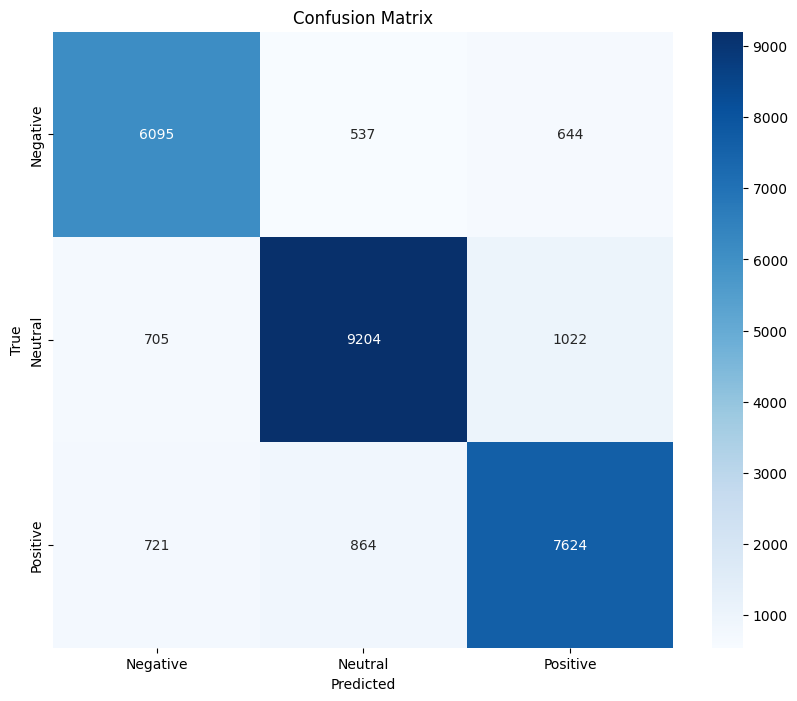

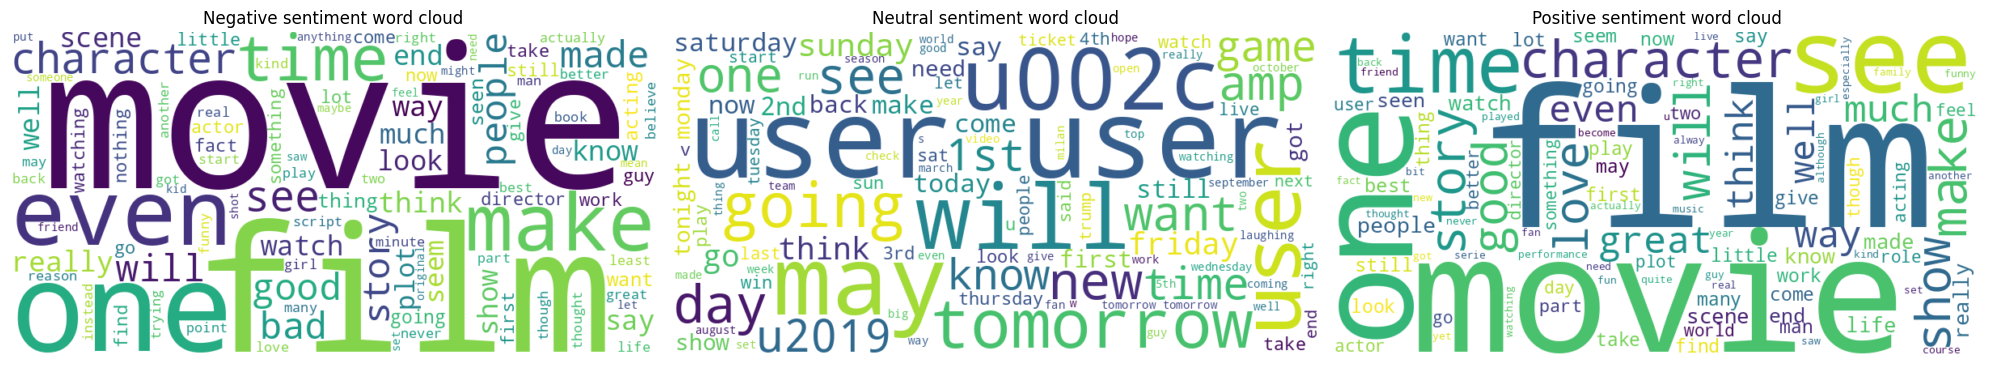

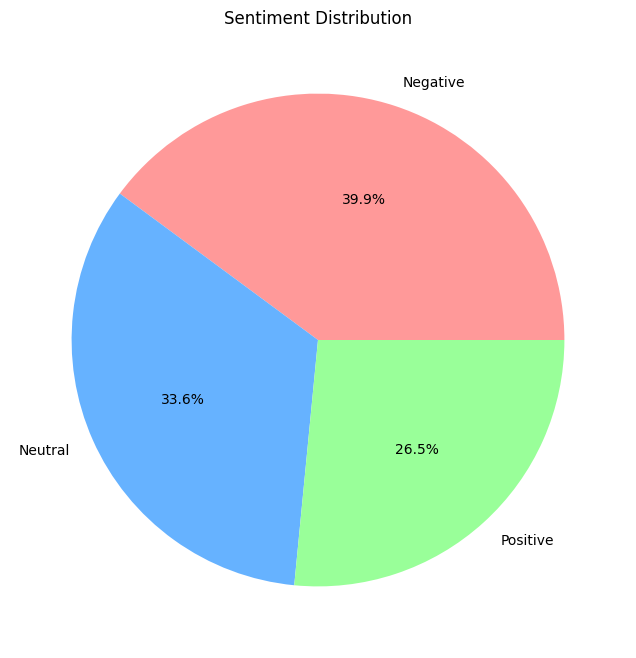

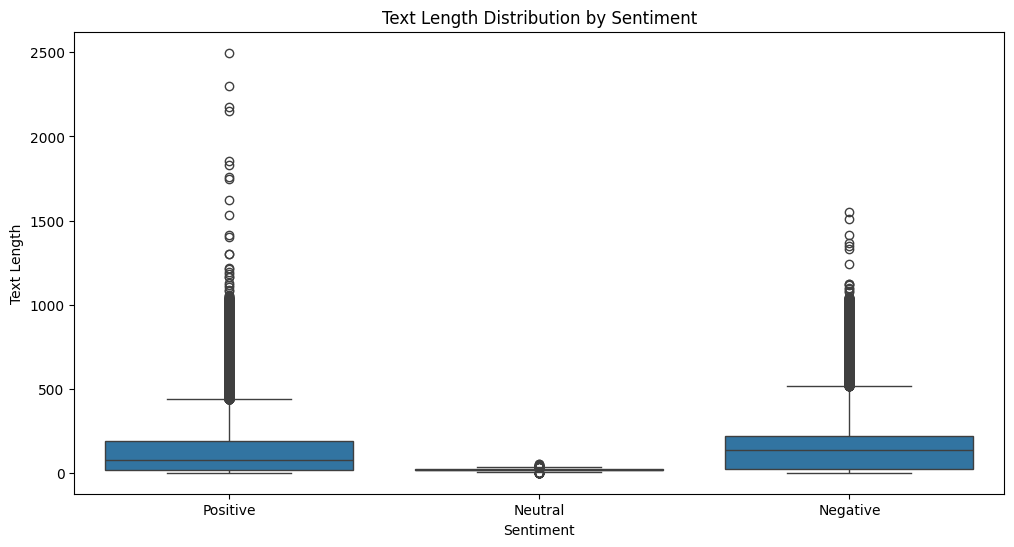

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.750 seconds.
DEBUG:jieba:Loading model cost 0.750 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


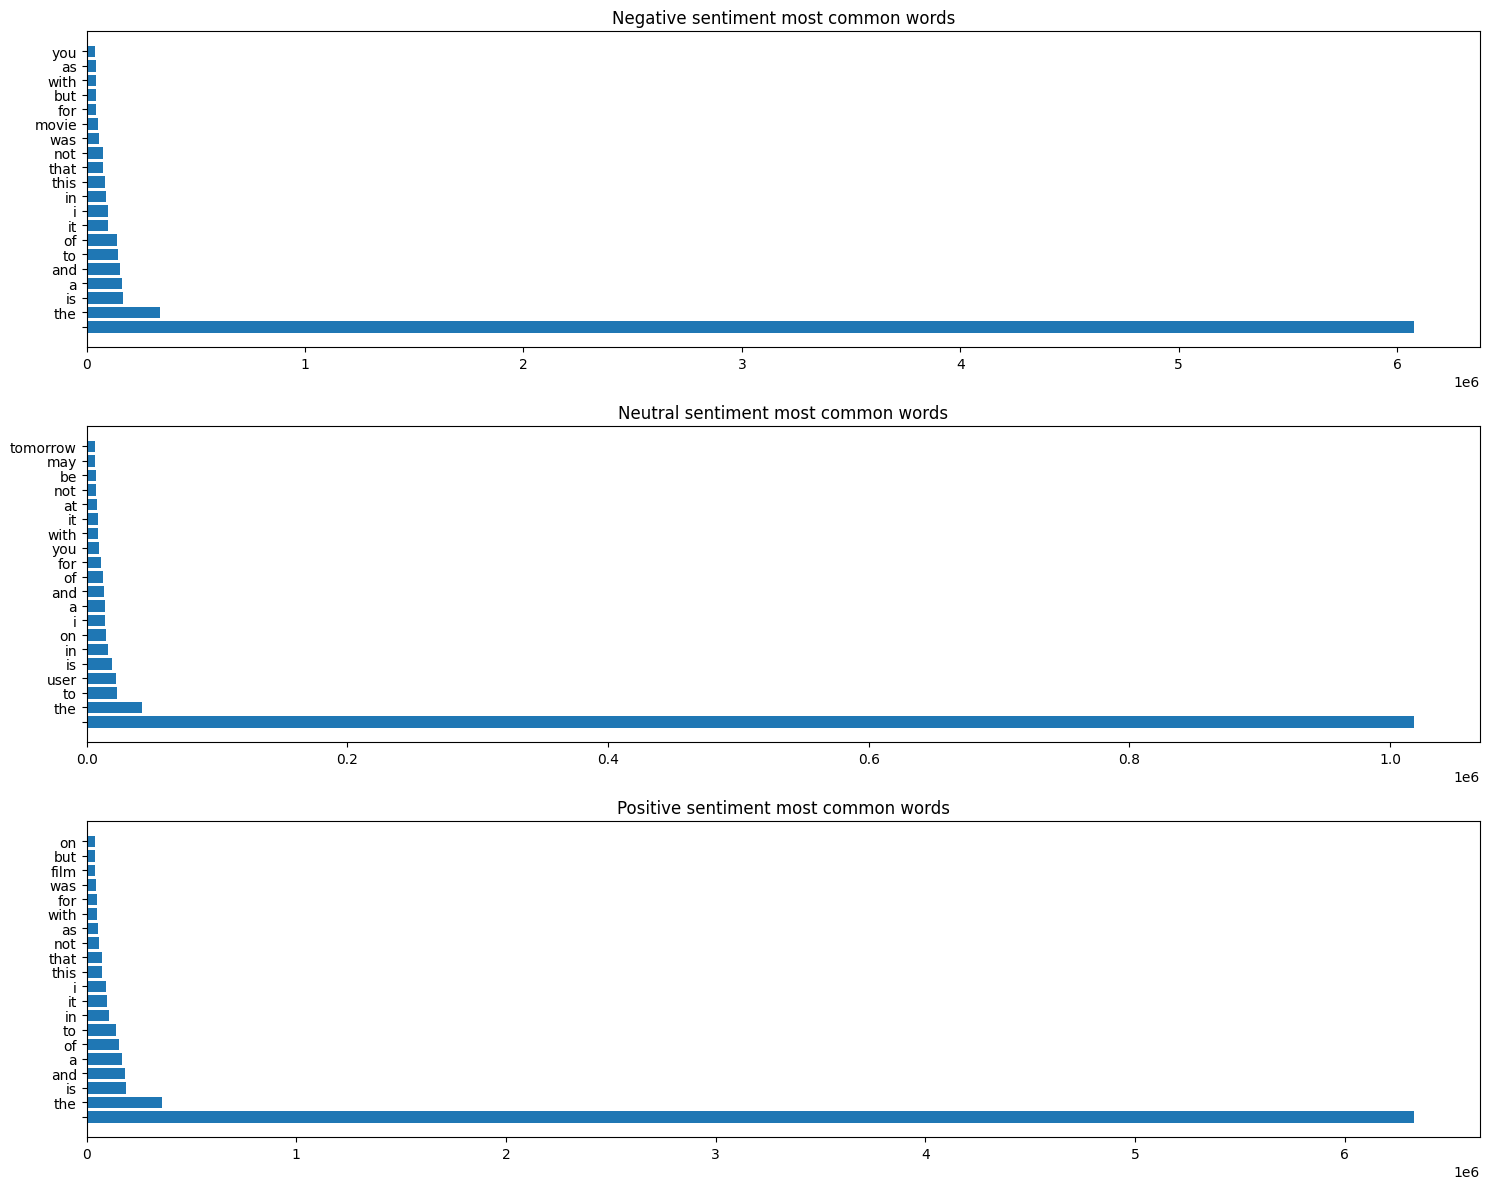

In [ ]:
visualize_results(cleaned_texts, labels, actual_labels, predictions)

In [ ]:
    # 加载结果
    with open('sentiment_results.pkl', 'rb') as f:
        results = pickle.load(f)

    actual_labels = results['actual_labels']
    predictions = results['predictions']
    cleaned_texts = results['cleaned_texts']
    labels = results['labels']


FileNotFoundError: [Errno 2] No such file or directory: 'sentiment_results.pkl'